# Image Infomation Extractor Experiment
- 이미지의 맥락수준을 기준으로 저,중,고 맥락 이미지로 구분하여 정보 추출 실험
- 맥락 수준이란, key information, key insights의 포함 정보를 의미
- key information, key insights는 context와 관련있지만 직접적으로 언급되지 않은 정보를 의미
- 또한 gpt-4o 모델과 gpt-4o-mini 모델을 비교함


### 결론
- gpt-4o 모델로 실험한 결과가 모든 맥락수준에서 정보 추출 정확도가 높았음.
- 비용 측면에서도 gpt-4o와 gpt-4o-mini 모델의 차이가 크지 않아서 gpt-4o 모델을 사용하는 것이 좋을 것으로 판단됨.


In [1]:
import os
import json
import yaml
from pprint import pprint

from IPython.display import Image, display

from typing import TypedDict, Annotated, List, Dict, Tuple

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import load_prompt

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
with open('../data/document/역도/documentParseGraph_state.json', 'r') as f:
    state = json.load(f)

class GraphState(TypedDict):
    filepath: Annotated[str, 'filepath']
    filepath_pdf: Annotated[str, 'pdf filepath']
    originData: Annotated[List[Dict], 'originData']
    documents: Annotated[List[Dict], 'documents']
    heading_structure: Annotated[List[str], 'heading structure. last heading is borderline']
    unused_elements: Annotated[List[Tuple[str, str]], 'unused elements']
    image_result: Annotated[List[Dict], 'result of image information extractor ']
    chart_result: Annotated[List[Dict], 'result of chart information extractor ']
    table_result: Annotated[List[Dict], 'result of table information extractor ']
    
state = GraphState(**state)

In [4]:
import base64

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        image_content = image_file.read()
        file_ext = os.path.splitext(image_path)[1].lower()

        if file_ext in ['.jpg', '.jpeg']:
            mime_type = 'image/jpeg'
        elif file_ext == '.png':
            mime_type = 'image/png'
        else:
            mime_type = 'image/unknown'

        return base64.b64encode(image_content).decode("utf-8"), mime_type

In [5]:
def load_prompt(yaml_file):
    with open(yaml_file, "r", encoding="utf-8") as file:
        return yaml.safe_load(file)

In [7]:
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field

class ImageInformationExtract(BaseModel):
    detail: str = Field(description='key insights and information visible in the IMAGE')
    entity: List[str] = Field(description="significant entities or objects in IMAGE")
    hypotheticalQuestions: List[str] = Field(description="relevant hypothetical questions")    

parser = PydanticOutputParser(pydantic_object=ImageInformationExtract)

In [8]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"detail": {"description": "key insights and information visible in the IMAGE", "title": "Detail", "type": "string"}, "entity": {"description": "significant entities or objects in IMAGE", "items": {"type": "string"}, "title": "Entity", "type": "array"}, "hypotheticalQuestions": {"description": "relevant hypothetical questions", "items": {"type": "string"}, "title": "Hypotheticalquestions", "type": "array"}}, "required": ["detail", "entity", "hypotheticalQuestions"]}\n```'

In [31]:
prompt = load_prompt('../prompt/information_image/image_20250227_01.yaml')
chat_prompt = ChatPromptTemplate.from_messages(prompt['messages'])
chat_prompt = chat_prompt.partial(format=parser.get_format_instructions())

In [32]:
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
image_chain = chat_prompt | llm

In [14]:
def draw_image_result(image_path, chain, context, title, parser):
    base64, mime_type = encode_image(image_path)
    result = chain.invoke({'base64_image': base64, 
                           'image_type': mime_type,
                           'context': context, 
                           'title': title,
                           'language': 'KOREAN'})

    display(Image(image_path))
    print(f"title: {title}")
    print(f"context: {context}")
    print("\n\n--------------------------------\n\n")

    result_parse = parser.parse(result.content)

    print(f"detail: {result_parse.detail}")
    print(f"entity: {result_parse.entity}")
    print(f"hypotheticalQuestions: {result_parse.hypotheticalQuestions}")
    print("\n\n--------------------------------\n\n")

    input_token = result.response_metadata['token_usage']['prompt_tokens']
    output_token = result.response_metadata['token_usage']['completion_tokens']

    input_dolor = round(input_token * 0.0001 * 0.15, 5)
    output_dolor = round(output_token * 0.0001 * 0.6, 5)

    input_won = round(input_dolor * 1440)
    output_won = round(output_dolor * 1440)

    print(f"input: {input_token},  {input_dolor}$, {input_won}원")
    print(f"output: {output_token},  {output_dolor}$, {output_won}원")
    return result

## gpt-4o-mini 모델 실험



### 1. 저맥락 이미지



In [15]:
summary_low = """역도는 기원전 1800년경 아일랜드의 무거운 물체 들기 경기에서 시작되었을 것으로 추정됩니다. 기원전 6-5세기 '힘의 시대'에 크로토나의 말로가 점진적 과부하 원리를 보여주었고, 동서양 모두에서 전통적인 중량 들어올리기가 존재했습니다. 근대 역도는 1800년대에 구츠무츠와 얀의 체조 운동으로 발전하였으며, 유젠 산도우와 아더 섹손 같은 유명 선수들로 인해 대중화되었습니다."""

low_1_title = "그림 1. 기원전 5세기 그리스에서 행해진 무거운 물체던지기1)"
low_2_title = "그림 2. 고대올림픽의 한 종목인 one hand twist1)"

low_1_image_path = '../data/experiment/informationExtract/image/low_1.png'
low_2_image_path = '../data/experiment/informationExtract/image/low_2.png'

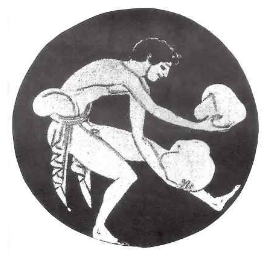

title: 그림 1. 기원전 5세기 그리스에서 행해진 무거운 물체던지기1)
context: 역도는 기원전 1800년경 아일랜드의 무거운 물체 들기 경기에서 시작되었을 것으로 추정됩니다. 기원전 6-5세기 '힘의 시대'에 크로토나의 말로가 점진적 과부하 원리를 보여주었고, 동서양 모두에서 전통적인 중량 들어올리기가 존재했습니다. 근대 역도는 1800년대에 구츠무츠와 얀의 체조 운동으로 발전하였으며, 유젠 산도우와 아더 섹손 같은 유명 선수들로 인해 대중화되었습니다.


--------------------------------


detail: 그림은 기원전 5세기 그리스에서 무거운 물체를 던지는 운동을 하는 남성을 묘사하고 있다. 남성은 두 개의 둥근 물체를 들고 있으며, 자세는 힘을 주어 던지려는 모습이다.
entity: 무거운 물체, 남성, 고대 그리스
hypotheticalQuestions: 이 그림에서 묘사된 운동은 고대 그리스의 어떤 스포츠와 관련이 있을까? 무거운 물체 던지기가 현대 스포츠에 미친 영향은 무엇일까?


--------------------------------


input: 1104,  0.01656$, 24원
output: 144,  0.00864$, 12원


AIMessage(content='```json\n{\n  "detail": "그림은 기원전 5세기 그리스에서 무거운 물체를 던지는 운동을 하는 남성을 묘사하고 있다. 남성은 두 개의 둥근 물체를 들고 있으며, 자세는 힘을 주어 던지려는 모습이다.",\n  "entity": "무거운 물체, 남성, 고대 그리스",\n  "hypotheticalQuestions": "이 그림에서 묘사된 운동은 고대 그리스의 어떤 스포츠와 관련이 있을까? 무거운 물체 던지기가 현대 스포츠에 미친 영향은 무엇일까?"\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 144, 'prompt_tokens': 1104, 'total_tokens': 1248, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'stop', 'logprobs': None}, id='run-a4eb6a17-9f60-4941-b769-8392d87c34f0-0', usage_metadata={'input_tokens': 1104, 'output_tokens': 144, 'total_tokens': 1248, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [16]:
draw_image_result(low_1_image_path, image_chain, summary_low, low_1_title, parser)

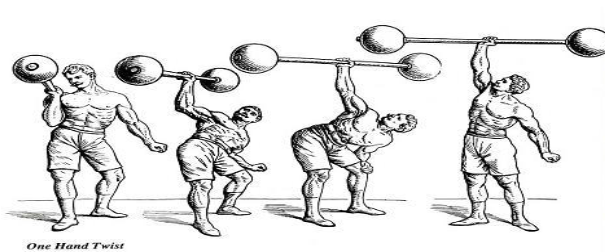

title: 그림 2. 고대올림픽의 한 종목인 one hand twist1)
context: 역도는 기원전 1800년경 아일랜드의 무거운 물체 들기 경기에서 시작되었을 것으로 추정됩니다. 기원전 6-5세기 '힘의 시대'에 크로토나의 말로가 점진적 과부하 원리를 보여주었고, 동서양 모두에서 전통적인 중량 들어올리기가 존재했습니다. 근대 역도는 1800년대에 구츠무츠와 얀의 체조 운동으로 발전하였으며, 유젠 산도우와 아더 섹손 같은 유명 선수들로 인해 대중화되었습니다.


--------------------------------


detail: 그림은 'One Hand Twist'라는 역도 종목을 수행하는 여러 단계의 동작을 보여줍니다. 각 단계에서 선수들은 한 손으로 바벨을 들어올리는 다양한 자세를 취하고 있습니다.
entity: One Hand Twist, 바벨, 역도 선수
hypotheticalQuestions: 이 종목의 기술적 요소는 무엇이며, 선수들이 이 동작을 수행할 때 어떤 신체적 조건이 필요한가? 또한, 이 종목이 현대 역도에 미친 영향은 무엇인가?


--------------------------------


input: 1235,  0.01852$, 27원
output: 130,  0.0078$, 11원


AIMessage(content='```json\n{\n  "detail": "그림은 \'One Hand Twist\'라는 역도 종목을 수행하는 여러 단계의 동작을 보여줍니다. 각 단계에서 선수들은 한 손으로 바벨을 들어올리는 다양한 자세를 취하고 있습니다.",\n  "entity": "One Hand Twist, 바벨, 역도 선수",\n  "hypotheticalQuestions": "이 종목의 기술적 요소는 무엇이며, 선수들이 이 동작을 수행할 때 어떤 신체적 조건이 필요한가? 또한, 이 종목이 현대 역도에 미친 영향은 무엇인가?"\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 130, 'prompt_tokens': 1235, 'total_tokens': 1365, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'stop', 'logprobs': None}, id='run-4c34dcf4-4574-465c-a8bb-5c982a7ad7a2-0', usage_metadata={'input_tokens': 1235, 'output_tokens': 130, 'total_tokens': 1365, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audi

In [17]:
draw_image_result(low_2_image_path, image_chain, summary_low, low_2_title, parser)

### 2. 중맥락 이미지

In [21]:
summary_middle_1 = "공식 경기에 사용되는 역도고무 원판은 최대 직경 450mm(허용오차 1mm)이다. 모든 원판은 중량을 뚜렷하게 표시해야 하며, 각각의 중량에 따라 고유의 원판색이있다. 또한 5kg 이하의 원판은 금속으로 만들어질 수 있다."
summary_middle_2 = "역도 스타트 시 바벨을 빨리 들려고 어깨로 당기면 상체가 후방으로 빠져 폭발적인 힘을 발휘하기 어렵습니다. 바벨이 무릎을 지날 때는 무릎을 최대한 앞으로 밀어넣어 각도를 110-115도 정도로 최소화해야 합니다. 역도의 주요 힘은 무릎 신전력에서 발생하며, 허리를 이용하면 지면반력을 제대로 얻지 못하고 몸이 후방으로 이동하게 됩니다. 발뒤꿈치는 들리지 않도록 해야 하는데, 들리면 발앞꿈치가 축이 되어 세컨드 풀 동작 시 몸이 후방으로 이동하게 됩니다. 올바른 무릎 넣기 동작은 스타트 자세에서 상체가 충분히 전진된 상태에서, 바벨이 무릎 위를 지날 때 하지는 지면을 누르고 펴지지 않도록 하며, 동시에 허리 신전근으로 고관절을 펴야 합니다. 그 후 바벨이 대퇴 1/2 지점을 지나면 무릎을 자연스럽게 넣으면서 라스트 풀 동작을 수행해야 합니다."

middle_1_title = "그림 13. 역도 고무원판(왼쪽부터 25, 20, 15, 10, 5 kg)"
middle_2_title = "그림 22. 바벨이 고관절 위치에 있을 때의 자세"

middle_1_image_path = '../data/experiment/informationExtract/image/middle_1.png'
middle_2_image_path = '../data/experiment/informationExtract/image/middle_2.png'

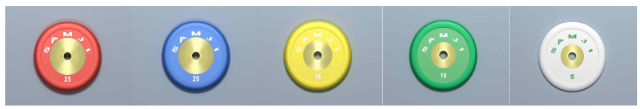

title: 그림 13. 역도 고무원판(왼쪽부터 25, 20, 15, 10, 5 kg)
context: 공식 경기에 사용되는 역도고무 원판은 최대 직경 450mm(허용오차 1mm)이다. 모든 원판은 중량을 뚜렷하게 표시해야 하며, 각각의 중량에 따라 고유의 원판색이있다. 또한 5kg 이하의 원판은 금속으로 만들어질 수 있다.


--------------------------------


detail: 역도 고무 원판은 각각 25kg(빨간색), 20kg(파란색), 15kg(노란색), 10kg(녹색), 5kg(흰색)으로 구분되며, 최대 직경은 450mm입니다.
entity: 역도 고무 원판, 중량(25kg, 20kg, 15kg, 10kg, 5kg), 색상(빨간색, 파란색, 노란색, 녹색, 흰색)
hypotheticalQuestions: 각 중량의 원판 색상은 어떻게 결정되며, 5kg 이하의 원판이 금속으로 만들어질 경우 어떤 장점이 있을까요?


--------------------------------


input: 1192,  0.01788$, 26원
output: 177,  0.01062$, 15원


AIMessage(content='```json\n{\n  "detail": "역도 고무 원판은 각각 25kg(빨간색), 20kg(파란색), 15kg(노란색), 10kg(녹색), 5kg(흰색)으로 구분되며, 최대 직경은 450mm입니다.",\n  "entity": "역도 고무 원판, 중량(25kg, 20kg, 15kg, 10kg, 5kg), 색상(빨간색, 파란색, 노란색, 녹색, 흰색)",\n  "hypotheticalQuestions": "각 중량의 원판 색상은 어떻게 결정되며, 5kg 이하의 원판이 금속으로 만들어질 경우 어떤 장점이 있을까요?"\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 177, 'prompt_tokens': 1192, 'total_tokens': 1369, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'stop', 'logprobs': None}, id='run-e5aa744d-1411-46df-a1d0-0f6dd3969d9b-0', usage_metadata={'input_tokens': 1192, 'output_tokens': 177, 'total_tokens': 1369, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details'

In [22]:
draw_image_result(middle_1_image_path, image_chain, summary_middle_1, middle_1_title, parser)

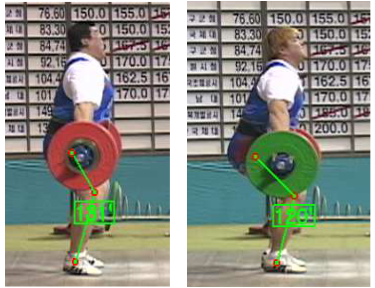

title: 그림 22. 바벨이 고관절 위치에 있을 때의 자세
context: 역도 스타트 시 바벨을 빨리 들려고 어깨로 당기면 상체가 후방으로 빠져 폭발적인 힘을 발휘하기 어렵습니다. 바벨이 무릎을 지날 때는 무릎을 최대한 앞으로 밀어넣어 각도를 110-115도 정도로 최소화해야 합니다. 역도의 주요 힘은 무릎 신전력에서 발생하며, 허리를 이용하면 지면반력을 제대로 얻지 못하고 몸이 후방으로 이동하게 됩니다. 발뒤꿈치는 들리지 않도록 해야 하는데, 들리면 발앞꿈치가 축이 되어 세컨드 풀 동작 시 몸이 후방으로 이동하게 됩니다. 올바른 무릎 넣기 동작은 스타트 자세에서 상체가 충분히 전진된 상태에서, 바벨이 무릎 위를 지날 때 하지는 지면을 누르고 펴지지 않도록 하며, 동시에 허리 신전근으로 고관절을 펴야 합니다. 그 후 바벨이 대퇴 1/2 지점을 지나면 무릎을 자연스럽게 넣으면서 라스트 풀 동작을 수행해야 합니다.


--------------------------------


detail: 이미지에서 두 명의 역도 선수가 바벨을 들고 있는 자세를 보여주고 있으며, 각 선수의 고관절 위치와 무릎 각도가 표시되어 있습니다. 왼쪽 선수의 무릎 각도는 110도, 오른쪽 선수의 무릎 각도는 120도로 나타나 있습니다.
entity: 역도 선수, 바벨, 무릎 각도, 고관절 위치
hypotheticalQuestions: 1. 두 선수의 무릎 각도가 역도 수행에 어떤 영향을 미칠까? 2. 바벨을 들 때 고관절의 위치가 힘 발휘에 미치는 영향은 무엇일까? 3. 각 선수의 자세에서 개선할 점은 무엇일까?


--------------------------------


input: 1212,  0.01818$, 26원
output: 177,  0.01062$, 15원


AIMessage(content='```json\n{\n  "detail": "이미지에서 두 명의 역도 선수가 바벨을 들고 있는 자세를 보여주고 있으며, 각 선수의 고관절 위치와 무릎 각도가 표시되어 있습니다. 왼쪽 선수의 무릎 각도는 110도, 오른쪽 선수의 무릎 각도는 120도로 나타나 있습니다.",\n  "entity": "역도 선수, 바벨, 무릎 각도, 고관절 위치",\n  "hypotheticalQuestions": "1. 두 선수의 무릎 각도가 역도 수행에 어떤 영향을 미칠까? 2. 바벨을 들 때 고관절의 위치가 힘 발휘에 미치는 영향은 무엇일까? 3. 각 선수의 자세에서 개선할 점은 무엇일까?"\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 177, 'prompt_tokens': 1212, 'total_tokens': 1389, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'stop', 'logprobs': None}, id='run-ac61ff21-3af2-4b9d-93f7-038b44df1163-0', usage_metadata={'input_tokens': 1212, 'output_tokens': 177, 'total_tokens': 1389, 'input_token_details': {'audio': 0, 'cache_

In [23]:
draw_image_result(middle_2_image_path, image_chain, summary_middle_2, middle_2_title, parser)

### 3. 고맥락 이미지

In [26]:
summary_high_1_2 = "한국 선수들의 역도 인상 동작 문제점으로는 상체가 후방으로 빠져있고, 힙이 무릎보다 낮으며, 허리의 S자형이 유지되지 않고, 바벨과 어깨 사이 길이가 짧은 점이 있습니다. 또한 스타트 이후 상체를 앞으로 빼앗기는 경향이 있고, 발이 오픈되지 않으며, 어깨와 허리를 과도하게 젖히는 문제가 있습니다. 중국 코치의 분석을 통해 도출된 올바른 인상 스타트 자세는 발을 약간 오픈하고 명치를 앞으로 내밀어 바벨에 몸을 최대한 붙이며, 힙을 들어 올려 상체와 바벨을 연결하는 팔이 탱탱하게 당겨진 상태로 자세를 잡아야 합니다. 또한 어깨가 바벨보다 앞쪽에 자연스럽게 위치하도록 하고, 허리와 대둔근 위쪽, 광배근을 강하게 발현하여 앞쪽으로 쏠리는 회전력을 버틸 수 있도록 해야 하며, 이때 상체를 인위적으로 젖히지 않는 것이 중요합니다."
summary_high_3 = "역도 스타트 시 바벨을 빨리 들려고 어깨로 당기면 상체가 후방으로 빠져 폭발적인 힘을 발휘하기 어렵습니다. 바벨이 무릎을 지날 때는 무릎을 최대한 앞으로 밀어넣어 각도를 110-115도 정도로 최소화해야 합니다. 역도의 주요 힘은 무릎 신전력에서 발생하며, 허리를 이용하면 지면반력을 제대로 얻지 못하고 몸이 후방으로 이동하게 됩니다. 발뒤꿈치는 들리지 않도록 해야 하는데, 들리면 발앞꿈치가 축이 되어 세컨드 풀 동작 시 몸이 후방으로 이동하게 됩니다. 올바른 무릎 넣기 동작은 스타트 자세에서 상체가 충분히 전진된 상태에서, 바벨이 무릎 위를 지날 때 하지는 지면을 누르고 펴지지 않도록 하며, 동시에 허리 신전근으로 고관절을 펴야 합니다. 그 후 바벨이 대퇴 1/2 지점을 지나면 무릎을 자연스럽게 넣으면서 라스트 풀 동작을 수행해야 합니다."

high_1_title = "그림 18. 한국 남녀선수들의 출발 자세(왼쪽 1,2)와 중국코치의 이상적 자세 시범(3,4)"
high_2_title = "그림 21. 중국선수들의 스타트 자세"
high_3_title = "그림 23. 무릎 넣기 동작을 수행하는 방법"

high_1_image_path = '../data/experiment/informationExtract/image/high_1.png'
high_2_image_path = '../data/experiment/informationExtract/image/high_2.png'
high_3_image_path = '../data/experiment/informationExtract/image/high_3.png'

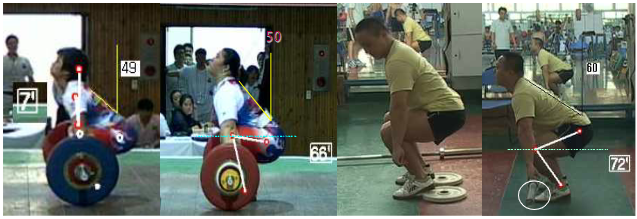

title: 그림 18. 한국 남녀선수들의 출발 자세(왼쪽 1,2)와 중국코치의 이상적 자세 시범(3,4)
context: 한국 선수들의 역도 인상 동작 문제점으로는 상체가 후방으로 빠져있고, 힙이 무릎보다 낮으며, 허리의 S자형이 유지되지 않고, 바벨과 어깨 사이 길이가 짧은 점이 있습니다. 또한 스타트 이후 상체를 앞으로 빼앗기는 경향이 있고, 발이 오픈되지 않으며, 어깨와 허리를 과도하게 젖히는 문제가 있습니다. 중국 코치의 분석을 통해 도출된 올바른 인상 스타트 자세는 발을 약간 오픈하고 명치를 앞으로 내밀어 바벨에 몸을 최대한 붙이며, 힙을 들어 올려 상체와 바벨을 연결하는 팔이 탱탱하게 당겨진 상태로 자세를 잡아야 합니다. 또한 어깨가 바벨보다 앞쪽에 자연스럽게 위치하도록 하고, 허리와 대둔근 위쪽, 광배근을 강하게 발현하여 앞쪽으로 쏠리는 회전력을 버틸 수 있도록 해야 하며, 이때 상체를 인위적으로 젖히지 않는 것이 중요합니다.


--------------------------------


detail: 한국 선수들의 출발 자세에서 상체가 후방으로 빠져있고, 힙이 무릎보다 낮으며, 허리의 S자형이 유지되지 않는 문제점이 관찰됨. 바벨과 어깨 사이의 길이가 짧고, 스타트 이후 상체가 앞으로 쏠리는 경향이 있음. 발이 오픈되지 않고, 어깨와 허리를 과도하게 젖히는 문제가 있음. 중국 코치의 이상적 자세는 발을 약간 오픈하고 명치를 앞으로 내밀며, 힙을 들어 올려 상체와 바벨을 연결하는 팔이 당겨진 상태를 유지해야 함.
entity: 한국 남녀 선수, 중국 코치, 바벨, 체중 훈련 장비
hypotheticalQuestions: 한국 선수들이 올바른 자세를 취하기 위해 어떤 추가적인 훈련이 필요할까? 중국 코치의 방법을 적용했을 때 선수들의 성과는 어떻게 변화할까? 각 선수의 신체 조건에 따라 최적의 자세는 어떻게 달라질 수 있을까?


--------------------------------


input: 1365,  0.02048$, 29원
o

AIMessage(content='```json\n{\n  "detail": "한국 선수들의 출발 자세에서 상체가 후방으로 빠져있고, 힙이 무릎보다 낮으며, 허리의 S자형이 유지되지 않는 문제점이 관찰됨. 바벨과 어깨 사이의 길이가 짧고, 스타트 이후 상체가 앞으로 쏠리는 경향이 있음. 발이 오픈되지 않고, 어깨와 허리를 과도하게 젖히는 문제가 있음. 중국 코치의 이상적 자세는 발을 약간 오픈하고 명치를 앞으로 내밀며, 힙을 들어 올려 상체와 바벨을 연결하는 팔이 당겨진 상태를 유지해야 함.",\n  "entity": "한국 남녀 선수, 중국 코치, 바벨, 체중 훈련 장비",\n  "hypotheticalQuestions": "한국 선수들이 올바른 자세를 취하기 위해 어떤 추가적인 훈련이 필요할까? 중국 코치의 방법을 적용했을 때 선수들의 성과는 어떻게 변화할까? 각 선수의 신체 조건에 따라 최적의 자세는 어떻게 달라질 수 있을까?"\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 251, 'prompt_tokens': 1365, 'total_tokens': 1616, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'stop', 'logprobs': None}, id='run-f095a0a4-aede-41d3-826b-7598c2ea72bd-

In [27]:
draw_image_result(high_1_image_path, image_chain, summary_high_1_2, high_1_title, parser)

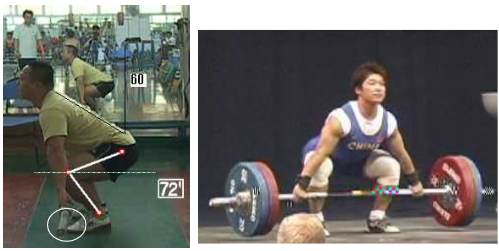

title: 그림 21. 중국선수들의 스타트 자세
context: 한국 선수들의 역도 인상 동작 문제점으로는 상체가 후방으로 빠져있고, 힙이 무릎보다 낮으며, 허리의 S자형이 유지되지 않고, 바벨과 어깨 사이 길이가 짧은 점이 있습니다. 또한 스타트 이후 상체를 앞으로 빼앗기는 경향이 있고, 발이 오픈되지 않으며, 어깨와 허리를 과도하게 젖히는 문제가 있습니다. 중국 코치의 분석을 통해 도출된 올바른 인상 스타트 자세는 발을 약간 오픈하고 명치를 앞으로 내밀어 바벨에 몸을 최대한 붙이며, 힙을 들어 올려 상체와 바벨을 연결하는 팔이 탱탱하게 당겨진 상태로 자세를 잡아야 합니다. 또한 어깨가 바벨보다 앞쪽에 자연스럽게 위치하도록 하고, 허리와 대둔근 위쪽, 광배근을 강하게 발현하여 앞쪽으로 쏠리는 회전력을 버틸 수 있도록 해야 하며, 이때 상체를 인위적으로 젖히지 않는 것이 중요합니다.


--------------------------------


detail: 중국 선수들의 올바른 스타트 자세는 발을 약간 오픈하고 명치를 앞으로 내밀며 바벨에 몸을 최대한 붙이는 것이 중요하다. 힙을 들어 올려 상체와 바벨을 연결하는 팔이 당겨진 상태를 유지해야 하며, 어깨는 바벨보다 앞쪽에 자연스럽게 위치해야 한다. 허리와 대둔근 위쪽, 광배근을 강하게 발현하여 회전력을 버틸 수 있도록 해야 한다.
entity: ['중국 선수', '바벨', '힙', '어깨', '허리', '대둔근', '광배근']
hypotheticalQuestions: ['한국 선수들이 중국 선수들의 스타트 자세를 어떻게 개선할 수 있을까?', '올바른 스타트 자세를 유지하기 위해 필요한 훈련 방법은 무엇일까?', '상체를 인위적으로 젖히지 않기 위해 어떤 기술적 요소가 필요할까?', '스타트 자세에서 발의 위치가 성과에 미치는 영향은 무엇일까?']


--------------------------------


input: 1219,  0.01828$, 26원
output: 263,  0.01578$,

AIMessage(content='```json\n{\n  "detail": "중국 선수들의 올바른 스타트 자세는 발을 약간 오픈하고 명치를 앞으로 내밀며 바벨에 몸을 최대한 붙이는 것이 중요하다. 힙을 들어 올려 상체와 바벨을 연결하는 팔이 당겨진 상태를 유지해야 하며, 어깨는 바벨보다 앞쪽에 자연스럽게 위치해야 한다. 허리와 대둔근 위쪽, 광배근을 강하게 발현하여 회전력을 버틸 수 있도록 해야 한다.",\n  "entity": [\n    "중국 선수",\n    "바벨",\n    "힙",\n    "어깨",\n    "허리",\n    "대둔근",\n    "광배근"\n  ],\n  "hypotheticalQuestions": [\n    "한국 선수들이 중국 선수들의 스타트 자세를 어떻게 개선할 수 있을까?",\n    "올바른 스타트 자세를 유지하기 위해 필요한 훈련 방법은 무엇일까?",\n    "상체를 인위적으로 젖히지 않기 위해 어떤 기술적 요소가 필요할까?",\n    "스타트 자세에서 발의 위치가 성과에 미치는 영향은 무엇일까?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 263, 'prompt_tokens': 1219, 'total_tokens': 1482, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': '

In [33]:
draw_image_result(high_2_image_path, image_chain, summary_high_1_2, high_2_title, parser)

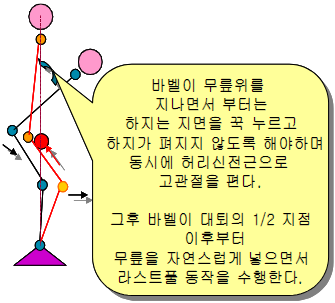

title: 그림 23. 무릎 넣기 동작을 수행하는 방법
context: 역도 스타트 시 바벨을 빨리 들려고 어깨로 당기면 상체가 후방으로 빠져 폭발적인 힘을 발휘하기 어렵습니다. 바벨이 무릎을 지날 때는 무릎을 최대한 앞으로 밀어넣어 각도를 110-115도 정도로 최소화해야 합니다. 역도의 주요 힘은 무릎 신전력에서 발생하며, 허리를 이용하면 지면반력을 제대로 얻지 못하고 몸이 후방으로 이동하게 됩니다. 발뒤꿈치는 들리지 않도록 해야 하는데, 들리면 발앞꿈치가 축이 되어 세컨드 풀 동작 시 몸이 후방으로 이동하게 됩니다. 올바른 무릎 넣기 동작은 스타트 자세에서 상체가 충분히 전진된 상태에서, 바벨이 무릎 위를 지날 때 하지는 지면을 누르고 펴지지 않도록 하며, 동시에 허리 신전근으로 고관절을 펴야 합니다. 그 후 바벨이 대퇴 1/2 지점을 지나면 무릎을 자연스럽게 넣으면서 라스트 풀 동작을 수행해야 합니다.


--------------------------------


detail: 무릎 넣기 동작은 바벨이 무릎 위를 지날 때 하체를 지면에 눌러주고 허리 신전근으로 고관절을 펴는 것이 중요하다. 바벨이 대퇴의 1/2 지점을 지나면 무릎을 자연스럽게 넣으면서 라스트 풀 동작을 수행해야 한다.
entity: ['바벨', '무릎', '고관절', '허리 신전근', '대퇴']
hypotheticalQuestions: ['무릎 넣기 동작을 잘 수행하기 위해 필요한 훈련 방법은 무엇인가?', '바벨을 들 때 상체의 위치가 힘에 미치는 영향은 어떤가?', '발뒤꿈치를 들지 않기 위한 효과적인 방법은 무엇인가?', '무릎을 자연스럽게 넣는 동작을 연습하기 위한 구체적인 기술은 무엇인가?']


--------------------------------


input: 1229,  0.01843$, 27원
output: 228,  0.01368$, 20원


AIMessage(content='```json\n{\n  "detail": "무릎 넣기 동작은 바벨이 무릎 위를 지날 때 하체를 지면에 눌러주고 허리 신전근으로 고관절을 펴는 것이 중요하다. 바벨이 대퇴의 1/2 지점을 지나면 무릎을 자연스럽게 넣으면서 라스트 풀 동작을 수행해야 한다.",\n  "entity": [\n    "바벨",\n    "무릎",\n    "고관절",\n    "허리 신전근",\n    "대퇴"\n  ],\n  "hypotheticalQuestions": [\n    "무릎 넣기 동작을 잘 수행하기 위해 필요한 훈련 방법은 무엇인가?",\n    "바벨을 들 때 상체의 위치가 힘에 미치는 영향은 어떤가?",\n    "발뒤꿈치를 들지 않기 위한 효과적인 방법은 무엇인가?",\n    "무릎을 자연스럽게 넣는 동작을 연습하기 위한 구체적인 기술은 무엇인가?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 228, 'prompt_tokens': 1229, 'total_tokens': 1457, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'stop', 'logprobs': None}, id='run-39121017-82f0-4b52-b763-a81707da0956-0', usage_metadata={'inp

In [34]:
draw_image_result(high_3_image_path, image_chain, summary_high_3, high_3_title, parser)

## gpt-4o 모델 실험


In [35]:
llm = ChatOpenAI(model='gpt-4o', temperature=0)
image_chain = chat_prompt | llm

### 1. 저맥락 이미지



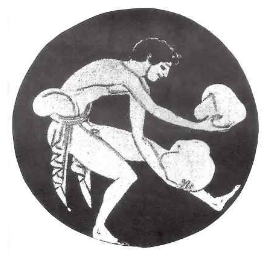

title: 그림 1. 기원전 5세기 그리스에서 행해진 무거운 물체던지기1)
context: 역도는 기원전 1800년경 아일랜드의 무거운 물체 들기 경기에서 시작되었을 것으로 추정됩니다. 기원전 6-5세기 '힘의 시대'에 크로토나의 말로가 점진적 과부하 원리를 보여주었고, 동서양 모두에서 전통적인 중량 들어올리기가 존재했습니다. 근대 역도는 1800년대에 구츠무츠와 얀의 체조 운동으로 발전하였으며, 유젠 산도우와 아더 섹손 같은 유명 선수들로 인해 대중화되었습니다.


--------------------------------


detail: 이미지는 기원전 5세기 그리스에서 무거운 물체를 던지는 모습을 보여줍니다. 인물은 두 손으로 큰 돌을 들고 있으며, 던지기 동작을 취하고 있습니다.
entity: ['그리스 인물', '무거운 돌']
hypotheticalQuestions: ['기원전 5세기 그리스에서 무거운 물체 던지기는 어떤 규칙과 형식으로 진행되었을까?', '이 시기의 그리스에서 무거운 물체 던지기는 어떤 사회적 또는 문화적 의미를 가졌을까?', '현대 역도와 비교했을 때, 고대 그리스의 무거운 물체 던지기 기술은 어떻게 발전했을까?']


--------------------------------


input: 1122,  0.01683$, 24원
output: 187,  0.01122$, 16원


AIMessage(content='```json\n{\n    "detail": "이미지는 기원전 5세기 그리스에서 무거운 물체를 던지는 모습을 보여줍니다. 인물은 두 손으로 큰 돌을 들고 있으며, 던지기 동작을 취하고 있습니다.",\n    "entity": ["그리스 인물", "무거운 돌"],\n    "hypotheticalQuestions": [\n        "기원전 5세기 그리스에서 무거운 물체 던지기는 어떤 규칙과 형식으로 진행되었을까?",\n        "이 시기의 그리스에서 무거운 물체 던지기는 어떤 사회적 또는 문화적 의미를 가졌을까?",\n        "현대 역도와 비교했을 때, 고대 그리스의 무거운 물체 던지기 기술은 어떻게 발전했을까?"\n    ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 187, 'prompt_tokens': 1122, 'total_tokens': 1309, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_197415291b', 'finish_reason': 'stop', 'logprobs': None}, id='run-f99771c5-3e6b-46ef-9585-e53b8505ebc3-0', usage_metadata={'input_tokens': 1122, 'output_tokens': 187, 'total_tokens': 1309, 'input_t

In [37]:
draw_image_result(low_1_image_path, image_chain, summary_low, low_1_title, parser)

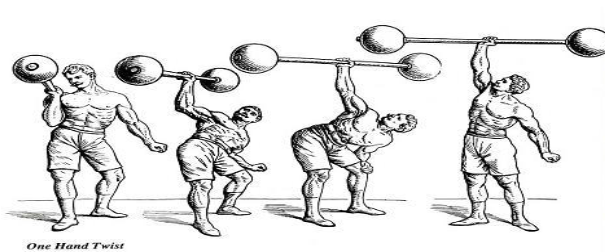

title: 그림 2. 고대올림픽의 한 종목인 one hand twist1)
context: 역도는 기원전 1800년경 아일랜드의 무거운 물체 들기 경기에서 시작되었을 것으로 추정됩니다. 기원전 6-5세기 '힘의 시대'에 크로토나의 말로가 점진적 과부하 원리를 보여주었고, 동서양 모두에서 전통적인 중량 들어올리기가 존재했습니다. 근대 역도는 1800년대에 구츠무츠와 얀의 체조 운동으로 발전하였으며, 유젠 산도우와 아더 섹손 같은 유명 선수들로 인해 대중화되었습니다.


--------------------------------


detail: 이미지는 'One Hand Twist'라는 고대 올림픽 종목을 수행하는 네 명의 남성을 보여줍니다. 각 남성은 한 손으로 바벨을 들어 올리고 있으며, 다양한 자세와 각도로 바벨을 들어 올리는 모습을 볼 수 있습니다.
entity: ['남성', '바벨']
hypotheticalQuestions: ['이 종목은 고대 올림픽에서 얼마나 인기가 있었을까?', 'One Hand Twist 기술은 현대 역도에 어떤 영향을 미쳤을까?', '이 기술을 수행하기 위해 필요한 신체적 조건은 무엇일까?']


--------------------------------


input: 1253,  0.01879$, 27원
output: 153,  0.00918$, 13원


AIMessage(content='```json\n{\n    "detail": "이미지는 \'One Hand Twist\'라는 고대 올림픽 종목을 수행하는 네 명의 남성을 보여줍니다. 각 남성은 한 손으로 바벨을 들어 올리고 있으며, 다양한 자세와 각도로 바벨을 들어 올리는 모습을 볼 수 있습니다.",\n    "entity": [\n        "남성",\n        "바벨"\n    ],\n    "hypotheticalQuestions": [\n        "이 종목은 고대 올림픽에서 얼마나 인기가 있었을까?",\n        "One Hand Twist 기술은 현대 역도에 어떤 영향을 미쳤을까?",\n        "이 기술을 수행하기 위해 필요한 신체적 조건은 무엇일까?"\n    ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 153, 'prompt_tokens': 1253, 'total_tokens': 1406, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_197415291b', 'finish_reason': 'stop', 'logprobs': None}, id='run-0db9ea45-55db-4d73-92b8-8fb6f9d0c5ea-0', usage_metadata={'input_tokens': 1253, 'output_tokens': 153, 'total_tokens':

In [38]:
draw_image_result(low_2_image_path, image_chain, summary_low, low_2_title, parser)

### 2. 중맥락 이미지

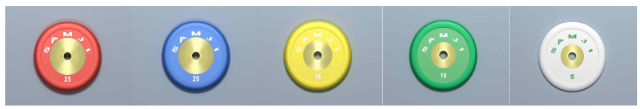

title: 그림 13. 역도 고무원판(왼쪽부터 25, 20, 15, 10, 5 kg)
context: 공식 경기에 사용되는 역도고무 원판은 최대 직경 450mm(허용오차 1mm)이다. 모든 원판은 중량을 뚜렷하게 표시해야 하며, 각각의 중량에 따라 고유의 원판색이있다. 또한 5kg 이하의 원판은 금속으로 만들어질 수 있다.


--------------------------------


detail: 이미지에는 25kg, 20kg, 15kg, 10kg, 5kg의 역도 고무 원판이 각각 빨간색, 파란색, 노란색, 녹색, 흰색으로 표시되어 있다.
entity: ['25kg 원판', '20kg 원판', '15kg 원판', '10kg 원판', '5kg 원판']
hypotheticalQuestions: ['각 원판의 색상이 국제 역도 연맹(IWF) 규정과 일치하는가?', '5kg 이하의 원판이 금속으로 만들어질 경우 어떤 장점이 있을까?', '원판의 색상이 경기 중 선수들에게 어떤 영향을 미칠 수 있을까?']


--------------------------------


input: 1210,  0.01815$, 26원
output: 185,  0.0111$, 16원


AIMessage(content='```json\n{\n    "detail": "이미지에는 25kg, 20kg, 15kg, 10kg, 5kg의 역도 고무 원판이 각각 빨간색, 파란색, 노란색, 녹색, 흰색으로 표시되어 있다.",\n    "entity": [\n        "25kg 원판",\n        "20kg 원판",\n        "15kg 원판",\n        "10kg 원판",\n        "5kg 원판"\n    ],\n    "hypotheticalQuestions": [\n        "각 원판의 색상이 국제 역도 연맹(IWF) 규정과 일치하는가?",\n        "5kg 이하의 원판이 금속으로 만들어질 경우 어떤 장점이 있을까?",\n        "원판의 색상이 경기 중 선수들에게 어떤 영향을 미칠 수 있을까?"\n    ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 185, 'prompt_tokens': 1210, 'total_tokens': 1395, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_197415291b', 'finish_reason': 'stop', 'logprobs': None}, id='run-dd53c48c-c408-45e2-906c-ce8e68ad9fd6-0', usage_metadata={'input_tokens': 1210, 'o

In [40]:
draw_image_result(middle_1_image_path, image_chain, summary_middle_1, middle_1_title, parser)

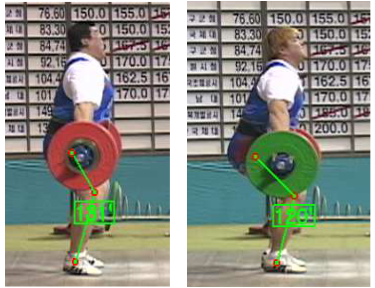

title: 그림 22. 바벨이 고관절 위치에 있을 때의 자세
context: 역도 스타트 시 바벨을 빨리 들려고 어깨로 당기면 상체가 후방으로 빠져 폭발적인 힘을 발휘하기 어렵습니다. 바벨이 무릎을 지날 때는 무릎을 최대한 앞으로 밀어넣어 각도를 110-115도 정도로 최소화해야 합니다. 역도의 주요 힘은 무릎 신전력에서 발생하며, 허리를 이용하면 지면반력을 제대로 얻지 못하고 몸이 후방으로 이동하게 됩니다. 발뒤꿈치는 들리지 않도록 해야 하는데, 들리면 발앞꿈치가 축이 되어 세컨드 풀 동작 시 몸이 후방으로 이동하게 됩니다. 올바른 무릎 넣기 동작은 스타트 자세에서 상체가 충분히 전진된 상태에서, 바벨이 무릎 위를 지날 때 하지는 지면을 누르고 펴지지 않도록 하며, 동시에 허리 신전근으로 고관절을 펴야 합니다. 그 후 바벨이 대퇴 1/2 지점을 지나면 무릎을 자연스럽게 넣으면서 라스트 풀 동작을 수행해야 합니다.


--------------------------------


detail: 이미지에는 두 명의 역도 선수가 바벨을 고관절 위치에 두고 있는 모습이 보입니다. 왼쪽 선수의 무릎 각도는 119도, 오른쪽 선수의 무릎 각도는 120도로 표시되어 있습니다. 두 선수 모두 발뒤꿈치가 지면에 닿아 있으며, 상체는 약간 앞으로 기울어져 있습니다.
entity: ['역도 선수', '바벨', '무릎 각도']
hypotheticalQuestions: ['무릎 각도가 110-115도일 때와 119-120도일 때의 차이는 무엇일까?', '발뒤꿈치가 들리지 않도록 하는 것이 역도 동작에 어떤 영향을 미칠까?', '상체의 기울기가 역도 성능에 미치는 영향은 무엇일까?']


--------------------------------


input: 1230,  0.01845$, 27원
output: 208,  0.01248$, 18원


AIMessage(content='```json\n{\n    "detail": "이미지에는 두 명의 역도 선수가 바벨을 고관절 위치에 두고 있는 모습이 보입니다. 왼쪽 선수의 무릎 각도는 119도, 오른쪽 선수의 무릎 각도는 120도로 표시되어 있습니다. 두 선수 모두 발뒤꿈치가 지면에 닿아 있으며, 상체는 약간 앞으로 기울어져 있습니다.",\n    "entity": [\n        "역도 선수",\n        "바벨",\n        "무릎 각도"\n    ],\n    "hypotheticalQuestions": [\n        "무릎 각도가 110-115도일 때와 119-120도일 때의 차이는 무엇일까?",\n        "발뒤꿈치가 들리지 않도록 하는 것이 역도 동작에 어떤 영향을 미칠까?",\n        "상체의 기울기가 역도 성능에 미치는 영향은 무엇일까?"\n    ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 208, 'prompt_tokens': 1230, 'total_tokens': 1438, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_197415291b', 'finish_reason': 'stop', 'logprobs': None}, id='run-09eca889-bcc0-4949-8395-2e58c84f92d4-0', usage_metadata={'in

In [41]:
draw_image_result(middle_2_image_path, image_chain, summary_middle_2, middle_2_title, parser)

### 3. 고맥락 이미지

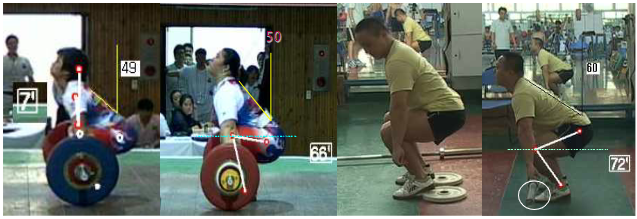

title: 그림 18. 한국 남녀선수들의 출발 자세(왼쪽 1,2)와 중국코치의 이상적 자세 시범(3,4)
context: 한국 선수들의 역도 인상 동작 문제점으로는 상체가 후방으로 빠져있고, 힙이 무릎보다 낮으며, 허리의 S자형이 유지되지 않고, 바벨과 어깨 사이 길이가 짧은 점이 있습니다. 또한 스타트 이후 상체를 앞으로 빼앗기는 경향이 있고, 발이 오픈되지 않으며, 어깨와 허리를 과도하게 젖히는 문제가 있습니다. 중국 코치의 분석을 통해 도출된 올바른 인상 스타트 자세는 발을 약간 오픈하고 명치를 앞으로 내밀어 바벨에 몸을 최대한 붙이며, 힙을 들어 올려 상체와 바벨을 연결하는 팔이 탱탱하게 당겨진 상태로 자세를 잡아야 합니다. 또한 어깨가 바벨보다 앞쪽에 자연스럽게 위치하도록 하고, 허리와 대둔근 위쪽, 광배근을 강하게 발현하여 앞쪽으로 쏠리는 회전력을 버틸 수 있도록 해야 하며, 이때 상체를 인위적으로 젖히지 않는 것이 중요합니다.


--------------------------------


detail: 이미지에는 한국 남녀 선수들의 출발 자세와 중국 코치의 이상적 자세 시범이 비교되어 있습니다. 한국 선수들은 상체가 뒤로 빠져 있고, 힙이 무릎보다 낮으며, 바벨과 어깨 사이의 거리가 짧습니다. 반면, 중국 코치는 발을 약간 오픈하고 명치를 앞으로 내밀어 바벨에 몸을 최대한 붙이며, 힙을 들어 올려 상체와 바벨을 연결하는 팔이 탱탱하게 당겨진 상태를 보여줍니다. 각도와 자세의 차이가 명확히 드러납니다.
entity: ['한국 남녀 선수', '중국 코치', '바벨', '힙', '어깨']
hypotheticalQuestions: ['한국 선수들이 중국 코치의 자세를 모방할 경우 어떤 성과 향상이 있을까?', '자세 교정이 선수들의 부상 예방에 어떤 영향을 미칠까?', '중국 코치의 자세가 다른 국가의 선수들에게도 효과적일까?']


--------------------------------


input: 1383,  0.02074$, 30원
ou

AIMessage(content='```json\n{\n    "detail": "이미지에는 한국 남녀 선수들의 출발 자세와 중국 코치의 이상적 자세 시범이 비교되어 있습니다. 한국 선수들은 상체가 뒤로 빠져 있고, 힙이 무릎보다 낮으며, 바벨과 어깨 사이의 거리가 짧습니다. 반면, 중국 코치는 발을 약간 오픈하고 명치를 앞으로 내밀어 바벨에 몸을 최대한 붙이며, 힙을 들어 올려 상체와 바벨을 연결하는 팔이 탱탱하게 당겨진 상태를 보여줍니다. 각도와 자세의 차이가 명확히 드러납니다.",\n    "entity": [\n        "한국 남녀 선수",\n        "중국 코치",\n        "바벨",\n        "힙",\n        "어깨"\n    ],\n    "hypotheticalQuestions": [\n        "한국 선수들이 중국 코치의 자세를 모방할 경우 어떤 성과 향상이 있을까?",\n        "자세 교정이 선수들의 부상 예방에 어떤 영향을 미칠까?",\n        "중국 코치의 자세가 다른 국가의 선수들에게도 효과적일까?"\n    ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 256, 'prompt_tokens': 1383, 'total_tokens': 1639, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_197415291b', 'finish

In [43]:
draw_image_result(high_1_image_path, image_chain, summary_high_1_2, high_1_title, parser)

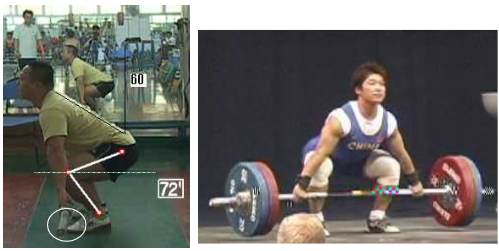

title: 그림 21. 중국선수들의 스타트 자세
context: 한국 선수들의 역도 인상 동작 문제점으로는 상체가 후방으로 빠져있고, 힙이 무릎보다 낮으며, 허리의 S자형이 유지되지 않고, 바벨과 어깨 사이 길이가 짧은 점이 있습니다. 또한 스타트 이후 상체를 앞으로 빼앗기는 경향이 있고, 발이 오픈되지 않으며, 어깨와 허리를 과도하게 젖히는 문제가 있습니다. 중국 코치의 분석을 통해 도출된 올바른 인상 스타트 자세는 발을 약간 오픈하고 명치를 앞으로 내밀어 바벨에 몸을 최대한 붙이며, 힙을 들어 올려 상체와 바벨을 연결하는 팔이 탱탱하게 당겨진 상태로 자세를 잡아야 합니다. 또한 어깨가 바벨보다 앞쪽에 자연스럽게 위치하도록 하고, 허리와 대둔근 위쪽, 광배근을 강하게 발현하여 앞쪽으로 쏠리는 회전력을 버틸 수 있도록 해야 하며, 이때 상체를 인위적으로 젖히지 않는 것이 중요합니다.


--------------------------------


detail: 이미지에는 두 명의 역도 선수가 각각 다른 스타트 자세를 취하고 있습니다. 왼쪽 선수는 상체가 앞으로 기울어져 있으며, 무릎 각도가 72도, 상체 각도가 60도로 표시되어 있습니다. 오른쪽 선수는 바벨을 잡고 있으며, 상체가 더 곧게 펴져 있는 모습입니다.
entity: ['역도 선수', '바벨', '무릎 각도', '상체 각도']
hypotheticalQuestions: ['왜 왼쪽 선수의 무릎 각도와 상체 각도가 각각 72도와 60도로 설정되었을까?', '오른쪽 선수의 자세가 역도 경기에서 더 유리한 이유는 무엇일까?', '각도 측정이 역도 선수의 성과에 어떤 영향을 미칠까?']


--------------------------------


input: 1219,  0.01828$, 26원
output: 210,  0.0126$, 18원


AIMessage(content='```json\n{\n    "detail": "이미지에는 두 명의 역도 선수가 각각 다른 스타트 자세를 취하고 있습니다. 왼쪽 선수는 상체가 앞으로 기울어져 있으며, 무릎 각도가 72도, 상체 각도가 60도로 표시되어 있습니다. 오른쪽 선수는 바벨을 잡고 있으며, 상체가 더 곧게 펴져 있는 모습입니다.",\n    "entity": [\n        "역도 선수",\n        "바벨",\n        "무릎 각도",\n        "상체 각도"\n    ],\n    "hypotheticalQuestions": [\n        "왜 왼쪽 선수의 무릎 각도와 상체 각도가 각각 72도와 60도로 설정되었을까?",\n        "오른쪽 선수의 자세가 역도 경기에서 더 유리한 이유는 무엇일까?",\n        "각도 측정이 역도 선수의 성과에 어떤 영향을 미칠까?"\n    ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 210, 'prompt_tokens': 1219, 'total_tokens': 1429, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_197415291b', 'finish_reason': 'stop', 'logprobs': None}, id='run-0afd17ed-8037-44cc-8f85-3c6c6420cf3a-0', usage

In [45]:
draw_image_result(high_2_image_path, image_chain, summary_high_1_2, high_2_title, parser)

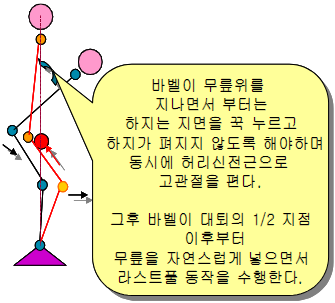

title: 그림 23. 무릎 넣기 동작을 수행하는 방법
context: 역도 스타트 시 바벨을 빨리 들려고 어깨로 당기면 상체가 후방으로 빠져 폭발적인 힘을 발휘하기 어렵습니다. 바벨이 무릎을 지날 때는 무릎을 최대한 앞으로 밀어넣어 각도를 110-115도 정도로 최소화해야 합니다. 역도의 주요 힘은 무릎 신전력에서 발생하며, 허리를 이용하면 지면반력을 제대로 얻지 못하고 몸이 후방으로 이동하게 됩니다. 발뒤꿈치는 들리지 않도록 해야 하는데, 들리면 발앞꿈치가 축이 되어 세컨드 풀 동작 시 몸이 후방으로 이동하게 됩니다. 올바른 무릎 넣기 동작은 스타트 자세에서 상체가 충분히 전진된 상태에서, 바벨이 무릎 위를 지날 때 하지는 지면을 누르고 펴지지 않도록 하며, 동시에 허리 신전근으로 고관절을 펴야 합니다. 그 후 바벨이 대퇴 1/2 지점을 지나면 무릎을 자연스럽게 넣으면서 라스트 풀 동작을 수행해야 합니다.


--------------------------------


detail: 이미지에는 역도 동작 중 무릎 넣기 방법에 대한 설명이 포함되어 있습니다. 바벨이 무릎을 지날 때 하지를 지면에 누르고 펴지지 않도록 하며, 허리 신전근으로 고관절을 펴야 한다고 설명하고 있습니다. 이후 바벨이 대퇴 1/2 지점을 지나면 무릎을 자연스럽게 넣으면서 라스트 풀 동작을 수행해야 한다고 강조하고 있습니다.
entity: ['바벨', '무릎', '허리 신전근', '고관절']
hypotheticalQuestions: ['무릎 넣기 동작이 역도 성능에 미치는 영향은 무엇일까?', '허리 신전근을 효과적으로 사용하는 방법은 무엇일까?', '발뒤꿈치가 들리지 않도록 하는 것이 왜 중요한가?']


--------------------------------


input: 1229,  0.01843$, 27원
output: 216,  0.01296$, 19원


AIMessage(content='```json\n{\n    "detail": "이미지에는 역도 동작 중 무릎 넣기 방법에 대한 설명이 포함되어 있습니다. 바벨이 무릎을 지날 때 하지를 지면에 누르고 펴지지 않도록 하며, 허리 신전근으로 고관절을 펴야 한다고 설명하고 있습니다. 이후 바벨이 대퇴 1/2 지점을 지나면 무릎을 자연스럽게 넣으면서 라스트 풀 동작을 수행해야 한다고 강조하고 있습니다.",\n    "entity": [\n        "바벨",\n        "무릎",\n        "허리 신전근",\n        "고관절"\n    ],\n    "hypotheticalQuestions": [\n        "무릎 넣기 동작이 역도 성능에 미치는 영향은 무엇일까?",\n        "허리 신전근을 효과적으로 사용하는 방법은 무엇일까?",\n        "발뒤꿈치가 들리지 않도록 하는 것이 왜 중요한가?"\n    ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 216, 'prompt_tokens': 1229, 'total_tokens': 1445, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_fc9f1d7035', 'finish_reason': 'stop', 'logprobs': None}, id='run-9619c848-9a13-4fa0-a8e9-3e66137d3976-0

In [46]:
draw_image_result(high_3_image_path, image_chain, summary_high_3, high_3_title, parser)